In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt

In [2]:
image_dir = Path('/content/drive/MyDrive/dataMine/data')
filepath = list(image_dir.glob(r'**/*.jpg'))

In [14]:
filepath

0       /content/drive/MyDrive/dataMine/data/0/1622099...
1       /content/drive/MyDrive/dataMine/data/0/1622101...
2       /content/drive/MyDrive/dataMine/data/0/1622098...
3       /content/drive/MyDrive/dataMine/data/0/1622101...
4       /content/drive/MyDrive/dataMine/data/0/1622098...
                              ...                        
1848    /content/drive/MyDrive/dataMine/data/1/1621492...
1849    /content/drive/MyDrive/dataMine/data/1/1621861...
1850    /content/drive/MyDrive/dataMine/data/1/1621590...
1851    /content/drive/MyDrive/dataMine/data/1/1621419...
1852    /content/drive/MyDrive/dataMine/data/1/1622093...
Name: Filepath, Length: 1853, dtype: object

In [3]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

In [4]:
filepath = pd.Series(filepath, name='Filepath').astype(str)
labels = pd.Series(labels, name='label')

image_df = pd.concat([filepath, labels], axis=1)

In [5]:
image_df

,Filepath,label
0,/content/drive/MyDrive/dataMine/data/0/1622099...,0
1,/content/drive/MyDrive/dataMine/data/0/1622101...,0
2,/content/drive/MyDrive/dataMine/data/0/1622098...,0
3,/content/drive/MyDrive/dataMine/data/0/1622101...,0
4,/content/drive/MyDrive/dataMine/data/0/1622098...,0
...,...,...
1848,/content/drive/MyDrive/dataMine/data/1/1621492...,1
1849,/content/drive/MyDrive/dataMine/data/1/1621861...,1
1850,/content/drive/MyDrive/dataMine/data/1/1621590...,1
1851,/content/drive/MyDrive/dataMine/data/1/1621419...,1


In [6]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as tfl

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

### Load image data

In [8]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [9]:
train_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 1038 validated image filenames belonging to 2 classes.
Found 259 validated image filenames belonging to 2 classes.
Found 556 validated image filenames belonging to 2 classes.


In [10]:
train_images.class_indices

{'0': 0, '1': 1}

### Training

In [11]:
# functional
inputs = tf.keras.Input(shape=(256, 256, 3))
xconv1 = tfl.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
max1 = tfl.MaxPool2D()(xconv1)
xconv2 = tfl.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(max1)
max2 = tfl.MaxPool2D()(xconv2)
pool = tfl.GlobalAveragePooling2D()(max2)
dense1 = tfl.Dense(128, activation='relu')(pool)
dense2 = tfl.Dense(128, activation='relu')(dense1)
outputs = tfl.Dense(1, activation='sigmoid')(dense2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


### compile model

In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
# if loss over flactuates, u might reduce the learning rate

history = model.fit(train_images, validation_data=val_images, epochs=100,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True
                        ),
                        tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_loss',
                            patience=3,
                        )
                    ])

Epoch 1/100
33/33 [==============================] - 49s 1s/step - loss: 0.6880 - accuracy: 0.5588 - val_loss: 0.6995 - val_accuracy: 0.5019 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 44s 1s/step - loss: 0.6837 - accuracy: 0.5636 - val_loss: 0.6870 - val_accuracy: 0.5058 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 44s 1s/step - loss: 0.6721 - accuracy: 0.5819 - val_loss: 0.6633 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 43s 1s/step - loss: 0.6459 - accuracy: 0.6416 - val_loss: 0.6173 - val_accuracy: 0.6950 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 44s 1s/step - loss: 0.6023 - accuracy: 0.6869 - val_loss: 0.6189 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 43s 1s/step - loss: 0.5642 - accuracy: 0.7274 - val_loss: 0.5066 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 43s 1s/step - loss: 0.5

In [15]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.44052
Test Accuracy: 81.47%


In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

18/18 [==============================] - 14s 765ms/step


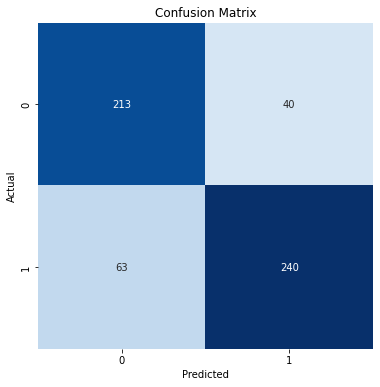

Classification Report:
-------------------
               precision    recall  f1-score   support

           0       0.77      0.84      0.81       253
           1       0.86      0.79      0.82       303

    accuracy                           0.81       556
   macro avg       0.81      0.82      0.81       556
weighted avg       0.82      0.81      0.82       556



In [25]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["0" ,"1"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["0" ,"1"])
plt.xticks(ticks=[0.5, 1.5], labels=["0" ,"1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-------------------\n", clr)

In [26]:
history.history

{'loss': [0.6880194544792175,
  0.6837252974510193,
  0.672144889831543,
  0.6459197402000427,
  0.6022549867630005,
  0.5641611218452454,
  0.5014793872833252,
  0.5006495714187622,
  0.5074024796485901,
  0.46980544924736023,
  0.46763357520103455,
  0.4333411753177643,
  0.43020695447921753,
  0.43397998809814453,
  0.40743330121040344,
  0.38637253642082214,
  0.39355936646461487,
  0.3752882778644562,
  0.37855422496795654,
  0.3888038992881775,
  0.3800538182258606,
  0.36765170097351074,
  0.3767588138580322,
  0.3704710006713867,
  0.3789673447608948,
  0.3708025813102722,
  0.3601953983306885,
  0.37368321418762207,
  0.3586917817592621,
  0.3736618161201477,
  0.35805973410606384,
  0.35264408588409424],
 'accuracy': [0.5587668418884277,
  0.5635837912559509,
  0.5818882584571838,
  0.6416184902191162,
  0.686897873878479,
  0.7273603081703186,
  0.7581888437271118,
  0.7707129120826721,
  0.7552986741065979,
  0.7793834209442139,
  0.7851637601852417,
  0.8082851767539978,
 

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Epoch')]

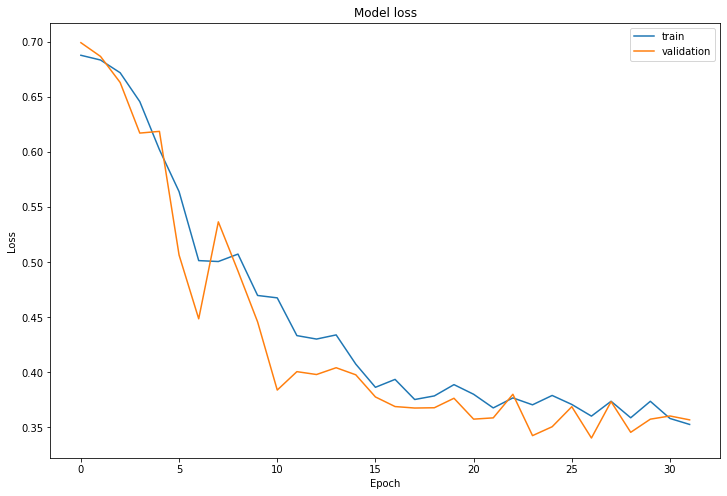

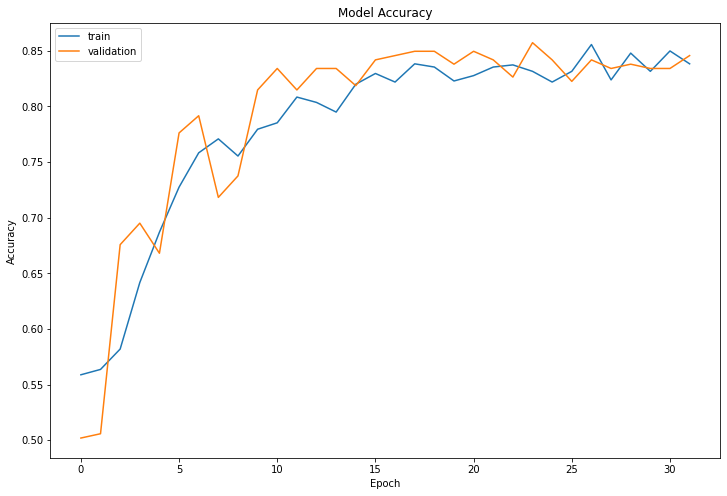

In [27]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')